In [5]:
import torch
from cnnf.model_cifar import WideResNet

In [6]:
model = WideResNet(40, 10, widen_factor=2)

In [7]:
model.load_state_dict(torch.load("models/CNNF_2_cifar.pt"))

<All keys matched successfully>

In [8]:
from torchvision import datasets, transforms

# batch_size = test_batch_size = 128
#
# train_transform_cifar = transforms.Compose(
#   [transforms.RandomHorizontalFlip(),
#    transforms.RandomCrop(32, padding=4),
#    transforms.ToTensor(),
#    transforms.Normalize([0.5] * 3, [0.5] * 3)])
#
# test_transform_cifar = transforms.Compose(
#   [transforms.ToTensor(),
#    transforms.Normalize([0.5] * 3, [0.5] * 3)])
#
# train_data = datasets.CIFAR10(
#     'data', train=True, transform=train_transform_cifar, download=True)
# test_data = datasets.CIFAR10(
#     'data', train=False, transform=test_transform_cifar, download=True)
# train_loader = torch.utils.data.DataLoader(
#   train_data, batch_size=batch_size,
#   shuffle=True, num_workers=4, pin_memory=True)
# test_loader = torch.utils.data.DataLoader(
#   test_data, batch_size=test_batch_size,
#   shuffle=True, num_workers=4, pin_memory=True)
dataloader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])),
    batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True)
eps = 0.063
eps_iter = 0.02
nb_iter = 7

Files already downloaded and verified


In [9]:
from eval import Evaluator
device = torch.device("cuda")
eval = Evaluator(device, model.to(device))

In [6]:
clean_acc = eval.clean_accuracy(dataloader, test='average')

Clean Test Acc 74.140


In [24]:
model1_name = 'CNN_cifar.pt'
model1_path = 'models/'+model1_name
model1 = WideResNet(40, 10, 2, 0.0, ind=0, cycles=0, res_param=0.0).to(device)
model1.load_state_dict(torch.load(model1_path))
transfer_acc = eval.attack_pgd_transfer(model1, dataloader, test='average', epsilon=eps, eps_iter=eps_iter, nb_iter=nb_iter)

PGD attack Acc 61.770


### Visualization

In [54]:
def run_cycles(model, data):
    intermediates = []
    # evaluate with all the iterations
    with torch.no_grad():
        data = data.cuda()
        model.reset()
        output, orig_feature, _, _, _ = model.forward(data, first=True, inter=True)
        ff_prev = orig_feature
        for i_cycle in range(model.cycles):
            reconstruct = model.forward(output, step='backward')
            intermediates.append(reconstruct)
            ff_current = ff_prev + model.res_param * (reconstruct - ff_prev)
            output = model.forward(ff_current, first=False)
            ff_prev = ff_current
    return output, intermediates

In [55]:
for batch_idx, (data, target) in enumerate(dataloader):
    data, target = data.to(device), target.to(device)
    output, intermediates = run_cycles(model, data)
    break

In [56]:
for i, state in enumerate(intermediates):
    intermediates[i] = (state*0.5+0.5).permute(0,2,3,1).cpu().detach().numpy()
    print(intermediates[i].shape)

(64, 32, 32, 3)
(64, 32, 32, 3)


In [57]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

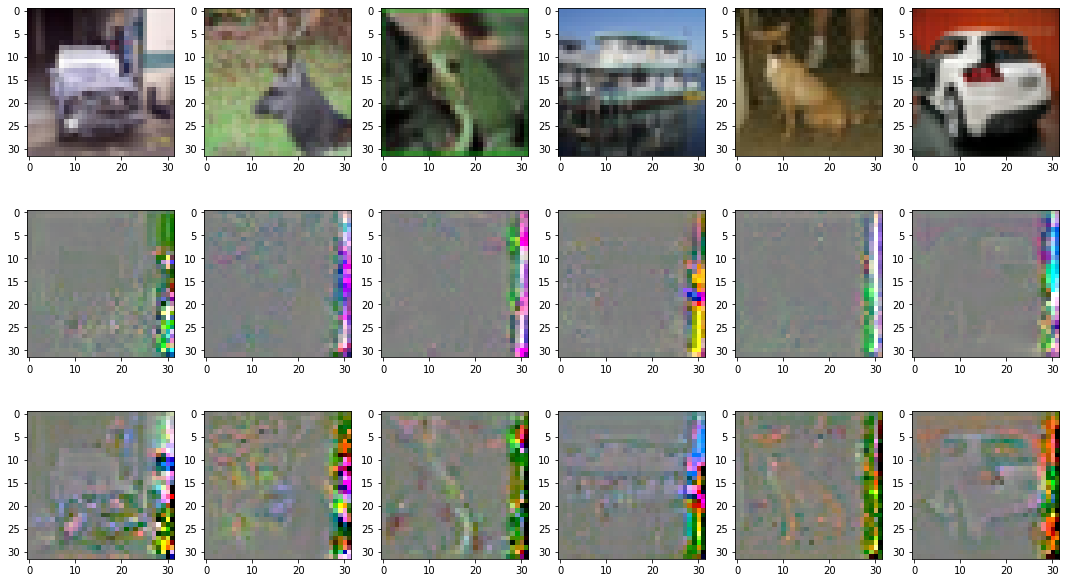

In [58]:
plt.tight_layout()
fig, axes = plt.subplots(nrows=len(intermediates)+1, ncols=6)
fig.set_size_inches(18.5, 10.5)
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i == 0:
            ax.imshow((data[j]*0.5+0.5).permute(1,2,0).cpu().detach().numpy())
        else:
            ax.imshow(intermediates[i-1][j])
plt.show()